# Simple Resourcce Model: Experiment Simulations 

## Dependencies 

In [24]:
# Packages
# Python 3.7, all packages used can be acquired via anaconda 3.7 installation
import numpy as np # numpy 1.15.4
import matplotlib # matplotlib 2.2.3
import matplotlib.pyplot as plt 
import pandas as pd # pandas 0.23.4
%matplotlib inline

# your versions:
print_versions = True
if print_versions:
    print('numpy: ', np.__version__, '\nmatplotlib: ', matplotlib.__version__,'\npandas: ', pd.__version__)

numpy:  1.15.4 
matplotlib:  2.2.3 
pandas:  0.23.4


## Functions 

In [44]:
# Task performance - a general function
def task_performance(resources, demand):
    if demand > 0:
        performance = resources/demand
    else:
        performance = np.nan
    return performance

def total_performance(task_performance_vector):
    performance = np.nansum(task_performance_vector) / sum(~np.isnan(task_performance_vector))
    return performance

# Controller - resource allocation rules & dynamics     
def allocate_resources(resource_pool_size, driving_resource_demand, probe_resource_demand):
    # output values
    driving_resources = 0
    probe_resources = 0
    new_resource_pool_size = resource_pool_size
    
    # if enough resources to do driving
    if driving_resource_demand <= new_resource_pool_size:
        driving_resources += driving_resource_demand
        new_resource_pool_size -= driving_resource_demand
        if probe_resource_demand <= new_resource_pool_size: # now if enough resources to allocate to probe
            probe_resources += probe_resource_demand
            new_resource_pool_size -= probe_resource_demand
        else: # not enough resoruces remain for probe
            probe_resources += new_resource_pool_size
            new_resource_pool_size -= new_resource_pool_size
    else:
        driving_resources += new_resource_pool_size
        new_resource_pool_size -= new_resource_pool_size
        probe_resources = 0
    return new_resource_pool_size, driving_resources, probe_resources

def forecaster(forecast_distance, current_time, demand_signal, probe_signal, resource_pool_size=100, sample_frequency=60):
    # Look ahead x time to see if there is a predictable demand (assumed to know it is coming)
    demand_forecast = demand_signal[current_time:int(np.round(current_time+(forecast_distance*sample_frequency),decimals=0))]
    
    if demand_forecast.max() > demand_signal[current_time]:
        new_resource_pool_size, driving_resources, probe_resources = allocate_resources(resource_pool_size,demand_forecast.max(),probe_signal[current_time])
    else:
        new_resource_pool_size, driving_resources, probe_resources = allocate_resources(resource_pool_size,demand_signal[current_time],probe_signal[current_time])
    return new_resource_pool_size, driving_resources, probe_resources

# Iterate over time and allocate resources appropriately
def run_one_trial(timeline, demand_driving_values, demand_probe_values, forecast = False, forecast_distance = None, resource_pool_size = 100, sample_frequency = 60):
    reserve_resource_vector = np.empty(shape = timeline.shape)
    driving_resource_vector = np.empty(shape = timeline.shape)
    probe_resource_vector = np.empty(shape = timeline.shape)
    driving_performance_vector = np.empty(shape = timeline.shape)
    probe_performance_vector = np.empty(shape = timeline.shape)
    
    for t in range(len(timeline)):
        # determine demand of driving at this step (probe is constant)
        driving_demand = demand_driving_values[t]
        probe_demand = demand_probe_values[t]

        # Allocate resources for this timestep
        if forecast:
            reserve_resource_vector[t], driving_resource_vector[t], probe_resource_vector[t] = forecaster(forecast_distance = forecast_distance,
                                                                                                         current_time = t,
                                                                                                         demand_signal = demand_driving_values,
                                                                                                         probe_signal = demand_probe_values,
                                                                                                         resource_pool_size = resource_pool_size,
                                                                                                         sample_frequency = sample_frequency)
        else:
            reserve_resource_vector[t], driving_resource_vector[t], probe_resource_vector[t] = allocate_resources(resource_pool_size, 
                                                                                                              driving_demand, 
                                                                                                              probe_demand)
        # Calculate performance
        driving_performance_vector[t] = task_performance(driving_resource_vector[t], driving_demand)
        probe_performance_vector[t] = task_performance(probe_resource_vector[t], probe_demand)
    return driving_performance_vector, probe_performance_vector, reserve_resource_vector, driving_resource_vector, probe_resource_vector

def create_demand_signal(timeline, init_demand = 20, step_magnitude = 50, onset = None, width = 2, sample_frequency = 60):
    demand_signal = np.empty(shape = timeline.shape) # init output
    if onset is None:
        onset = np.random.uniform(low = timeline.min(), high = timeline.max() - width, size = 1) # rv for time of signal, in seconds
    time_start_idx = int(np.round(sample_frequency * (onset - timeline.min()), decimals = 0))
    time_stop_idx = int(time_start_idx + (width * sample_frequency))
    
    # fill in the signal
    demand_signal[:] = init_demand
    demand_signal[time_start_idx:] = step_magnitude
    demand_signal[time_stop_idx:] = init_demand
    
    return demand_signal, onset

def simulate_experiment(n_trials,timeline, forecast = False, forecast_time = None, driving_difficulty = 90, onset = 4, driving_width = 2, resource_pool_size = 100, init_driving_demand = 40,init_probe_demand=0, step_magnitude=30, width=2):
    
    driving_performance = np.empty(shape = (n_trials,))
    probe_performance = np.empty(shape = (n_trials,))
    probe_onsets = np.empty(shape = (n_trials,))

    for n in range(n_trials):
        probe_signal, t_probe_onset = create_demand_signal(timeline, init_demand = init_probe_demand, 
                                                           step_magnitude = step_magnitude, width = width)
        driving_signal, t_driving_onset = create_demand_signal(timeline, init_demand = init_driving_demand, 
                                                               onset = onset, step_magnitude = driving_difficulty, 
                                                               width = driving_width)
        driving_performance_vector, probe_performance_vector, reserve_resource_vector, driving_resource_vector, probe_resource_vector = run_one_trial(timeline,
                                                                                                                                                      driving_signal,
                                                                                                                                                      probe_signal,
                                                                                                                                                      forecast,
                                                                                                                                                      forecast_time,
                                                                                                                                                      resource_pool_size,
                                                                                                                                                      sample_frequency)
        driving_performance[n] = total_performance(driving_performance_vector)
        probe_performance[n] = total_performance(probe_performance_vector)
        probe_onsets[n] = t_probe_onset
    experiment_dataframe = pd.DataFrame({'driving':driving_performance,'probe':probe_performance,'onset':probe_onsets,'onset_binned':np.round(probe_onsets,decimals=1)})
    return experiment_dataframe

def plot_task_demands(timeline, demand_driving_values, demand_probe_values):
    plt.plot(timeline, demand_driving_values);
    plt.plot(timeline, demand_probe_values)
    plt.xlabel('time (s)');
    plt.ylabel('Task Demand');
    plt.legend(['Driving','Probe']);
    plt.ylim([0,100]);
    
def plot_task_resources(timeline, driving_resource_vector, probe_resource_vector):
    plt.plot(timeline, driving_resource_vector);
    plt.plot(timeline, probe_resource_vector)
    plt.xlabel('time (s)');
    plt.ylabel('Task Resources');
    plt.legend(['Driving','Probe']);
    plt.ylim([0,100]);

def plot_task_performance(timeline, driving_performance_vector, probe_performance_vector):
    plt.plot(timeline, driving_performance_vector);
    plt.plot(timeline, probe_performance_vector)
    plt.xlabel('time (s)');
    plt.ylabel('Task Performance');
    plt.legend(['Driving','Probe']);
    plt.ylim([0,1.05]);
    
def plot_experiment_results(experiment_dataframe, experiment_title = ''):
    plt.figure();
    experiment_dataframe.groupby('onset_binned').driving.mean().plot();
    experiment_dataframe.groupby('onset_binned').probe.mean().plot();
    plt.plot([onset,onset],[.2,1], 'k');
    plt.plot([6,6],[.2,1], 'k--')
    plt.legend(['driving','probe','difficulty onset','difficulty offset']);
    plt.ylabel('Performance');
    plt.xlabel('Probe Onset Time (s)');
    plt.title('Simple Resource Sharing Model: ' + experiment_title);

def plot_probe_results(save_figure = False, save_name = 'test'):
    plt.figure(figsize=(7,5));
    # Plot the probe performance results
    experiment1_dataframe.groupby('onset_binned').probe.mean().plot(kind = 'line', color = 'r');
    experiment2_dataframe.groupby('onset_binned').probe.mean().plot(kind = 'line', color = 'r', linestyle = 'dashed');
    experiment3_dataframe.groupby('onset_binned').probe.mean().plot(kind = 'line', color = 'g');
    experiment4_dataframe.groupby('onset_binned').probe.mean().plot(kind = 'line', color = 'g', linestyle = 'dashed');
    
    # plot the onset for the driving times (currently these are manually input, but ideally have a variable assigned when )
    plt.plot([onset,onset],[.2,1], 'k');
    plt.plot([onset+driving_width,onset+driving_width],[.2,1], 'k-.')
    plt.legend(['difficult - certain','difficult - uncertain' , 
                'easy - certain', 'easy - uncertain', 
                'driving signal onset','driving signal offset']);
    plt.ylabel('Probe Performance');
    plt.xlabel('Probe Onset Time (s)');
    plt.title('Simple Resource Sharing Model');
    if save_figure:
        plt.savefig(save_name+'.png')

In [45]:
# Initialize Parameters

# Resource pools
resource_pool_size = 100 # Max amount of resources - should keep at 100, or things might break

# Task demands
init_driving_demand = 40 # background resource demand for driving
init_probe_demand = 0 # background demand for the probe - should keep at zero unless probe is present

driving_difficulty = 90 # Resource demand of driving difficulty obstacle
probe_demand = 30 # resource demand of probe when it appears

onset = 4 # time at which driving signal arrives to controller
# Note: the probe timings are uniformly sampled currently. If you'd like to change this, adjust the call for 'create_demand_signal' in sim function

driving_width = 2 # seconds of driving manipulation
probe_width = 2 # width of time which probe demands attention on (cannot be >= 1/2 max_task_time above)

# Time & Sampling
max_task_time = 10 # Task length in seconds
sample_frequency = 60 # samples / second
n_trials = 125 # number of trials to simulate using the above parameters

timeline = np.linspace(0, max_task_time, num = max_task_time*sample_frequency) # our simple time axis

In [46]:
exp_df = simulate_experiment(n_trials = 125, # number of trials in this condition
                             timeline = timeline, 
                             driving_difficulty = driving_difficulty, # Resource demand of driving difficulty obstacle
                             forecast_time = onset, # time at which driving signal arrives to controller
                             driving_width = driving_width, # seconds of driving manipulation
                             resource_pool_size = resource_pool_size, # max resource pool - should always keep at 100, or things may break.
                             init_driving_demand = init_driving_demand, # background resource demand for driving
                             init_probe_demand = init_probe_demand, # background demand for the probe - should keep at zero unless probe is present
                             step_magnitude = probe_demand, # resource demand of probe when it appears
                             width = probe_width # width of time which probe demands attention on (cannot be >= 1/2 max_task_time above)
                            )

In [47]:
plot_experiment_results(exp_df, experiment_title = '')

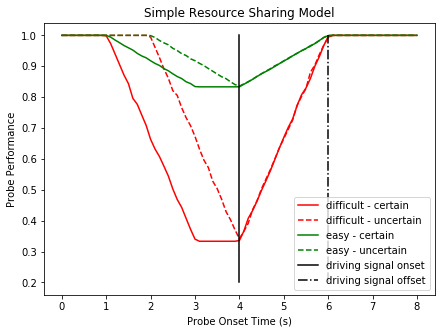

In [50]:
# Say you want to compare performance on a probe over multiple experimental conditions

# Difficult - uncertain
experiment2_dataframe = simulate_experiment(n_trials = 500, timeline = timeline, driving_difficulty = 90, 
                                            onset = 4, driving_width = 2, resource_pool_size = 100, 
                                            init_driving_demand = 40, init_probe_demand=0, step_magnitude=30, width=2)
# easy - uncertain
experiment4_dataframe = simulate_experiment(n_trials = 500, timeline = timeline, driving_difficulty = 75,
                                            onset = 4, driving_width = 2, resource_pool_size = 100,
                                            init_driving_demand = 40, init_probe_demand = 0, step_magnitude=30, width=2)
# difficult - certain
experiment1_dataframe = simulate_experiment(n_trials = 500, timeline = timeline, forecast = True,
                                            forecast_time = 1, driving_difficulty = 90, 
                                            onset = 4, driving_width = 2, resource_pool_size = 100, 
                                            init_driving_demand = 40, init_probe_demand=0, step_magnitude=30, width=2)
# easy - certain
experiment3_dataframe = simulate_experiment(n_trials = 500, timeline = timeline, forecast = True,
                                            forecast_time = 1, driving_difficulty = 75,
                                            onset = 4, driving_width = 2, resource_pool_size = 100,
                                            init_driving_demand = 40, init_probe_demand = 0, step_magnitude=30, width=2)
plot_probe_results()